In [1]:
import os
os.chdir("..")
from data.data_classes import *
from data.datamodules import *
import matplotlib.pyplot as plt
import numpy as np
from data.data_classes import *
from enums import Partition
from models.GAT_Modelv5 import GAT_Modelv5
from torch_geometric.data import Batch

In [17]:
# Load datamodule
data_module = Graph_DataModule_CSV(
    dataset=MyHELEN(),
    num_segments=256,
    batch_size=1,
    mode=Partition.CuPID,
    features={"x_center":True, "y_center":True, "colour":True, "width":True, "height":True, "stdev":True}
)

# Load model
model_ckpt = r"saved\HELEN_CP_256_DataModule\XYCWHS\GAT_Modelv5\Run_ID__2024-09-26__03-10-35\checkpoints\last.pt"
model = GAT_Modelv5(data_module.num_features, data_module.num_classes)
model.load_state_dict(torch.load(model_ckpt, weights_only=True))
model = model.eval()

In [14]:
def plot(original_image, partitioned_image, gt_landmarks, pr_landmarks):
    # Plotting
    _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 10))
    fontsize = 8

    ax1.imshow(original_image)
    for coord in gt_landmarks:
        ax1.scatter(*coord, c="red", s=1)
    ax1.set_title("Original Image w/ Ground Truth Landmarks", fontsize=fontsize)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2.imshow(partitioned_image)
    for coord in gt_landmarks:
        ax2.scatter(*coord, c="red", s=1)
    ax2.set_title("Partitioned Image w/ Ground Truth Landmarks", fontsize=fontsize)
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax3.imshow(original_image)
    for coord in pr_landmarks:
        ax3.scatter(*coord, c="red", s=1)
    ax3.set_title("Original Image w/ Predicted Landmarks", fontsize=fontsize)
    ax3.set_xticks([])
    ax3.set_yticks([])

    plt.show()

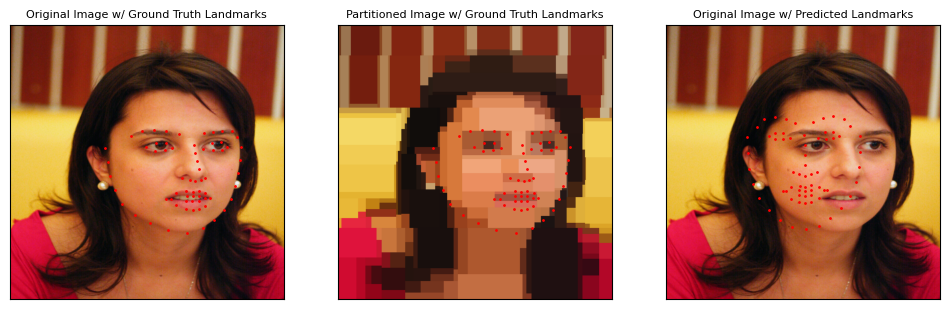

In [18]:
# Image index
idx = 3

# Retrieve information
original_image, gt_landmarks = data_module.test_set[idx]
partitioned_image = data_module.partition_test_set[idx][0]
graph_data_object = data_module.graph_test_set[idx]
batch = Batch.from_data_list([graph_data_object])
pr_landmarks = model(batch.x.float(), batch.edge_index, batch.batch)

gt_landmarks = np.array(gt_landmarks).reshape((-1, 2))
pr_landmarks = pr_landmarks.detach().numpy().reshape((-1, 2))

plot(original_image, partitioned_image, gt_landmarks, pr_landmarks)